<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#LinearRegression" data-toc-modified-id="LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>LinearRegression</a></span></li><li><span><a href="#CatBoost" data-toc-modified-id="CatBoost-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>CatBoost</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

**Ситуация**: компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель**: построить модель для предсказания количества заказов такси на следующий час.

**Примечания**: значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import pacf
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_pacf
RANDOM_STATE = 12345

In [2]:
try:
    data = pd.read_csv('C:/Users/borod/OneDrive/Рабочий стол/DS/project11_taxi/taxi.csv',index_col=[0],parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv',index_col=[0],parse_dates=[0])

Сделали дату индексом и перевели в тип datetime64.

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Предоставлены данные с марта 2018 по август 2018.

In [4]:
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим, в хронологическом ли порядке расположены даты.

In [5]:
print(data.index.is_monotonic)

True


Проведём ресемплирование по одному часу.

In [6]:
data = data.resample('1H').sum()
data.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Посмотрим на скользящее среднее и скользящее стандартное отклонение.

<AxesSubplot:xlabel='datetime'>

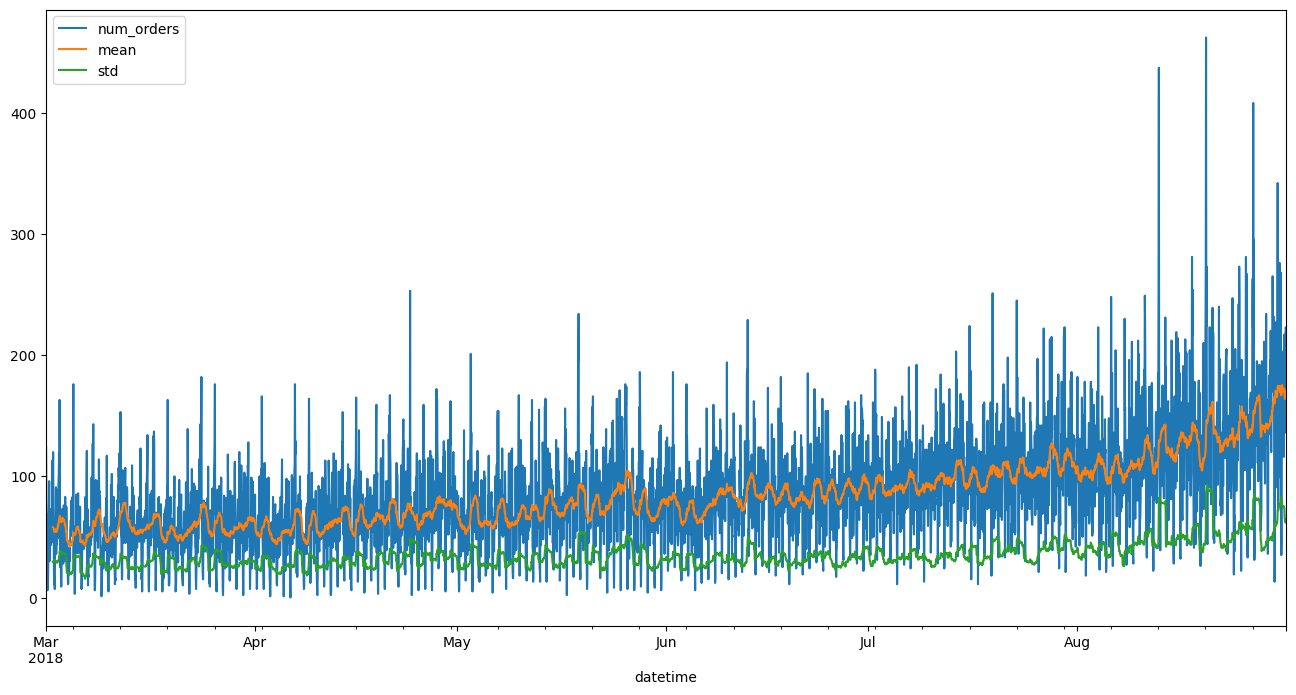

In [7]:
data['mean'] = data['num_orders'].rolling(25).mean()
data['std'] = data['num_orders'].rolling(25).std()
data.plot(figsize=(16,8))

In [8]:
data = data.drop(['mean','std'],axis =1)

Посмотрим на динамику заказов с ресемплированием по неделям и месяцам.

In [9]:
weeks = data.resample('1W').sum()
months= data.resample('1M').sum()

Наблюдаем положительную динамику по месяцам. По неделям аналогично, однако присутствуют некоторые отклонения от положительного роста.

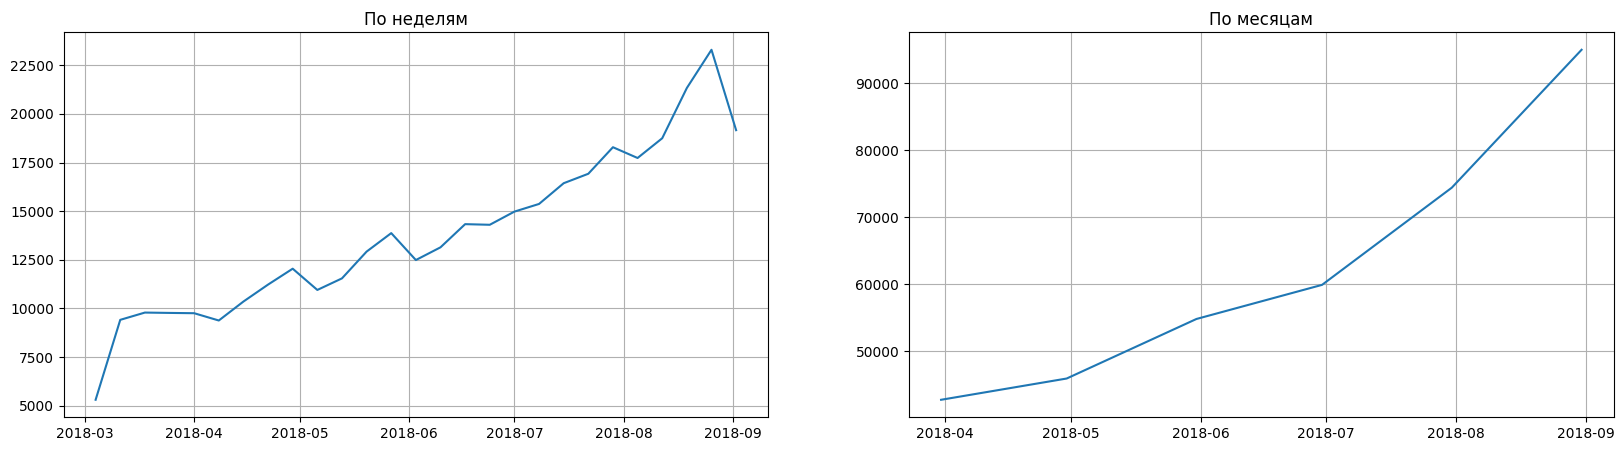

In [10]:
figure, axis = plt.subplots(1,2,figsize=(20,5))
axis[0].plot(weeks.index,weeks['num_orders'])
axis[0].set_title('По неделям')
axis[0].grid()
axis[1].plot(months.index, months['num_orders'])
axis[1].set_title('По месяцам')
axis[1].grid()
plt.show()

Теперь разложим временной ряд на тренд и сезонность. Также посмотрим сезонность в течение дня и недели.

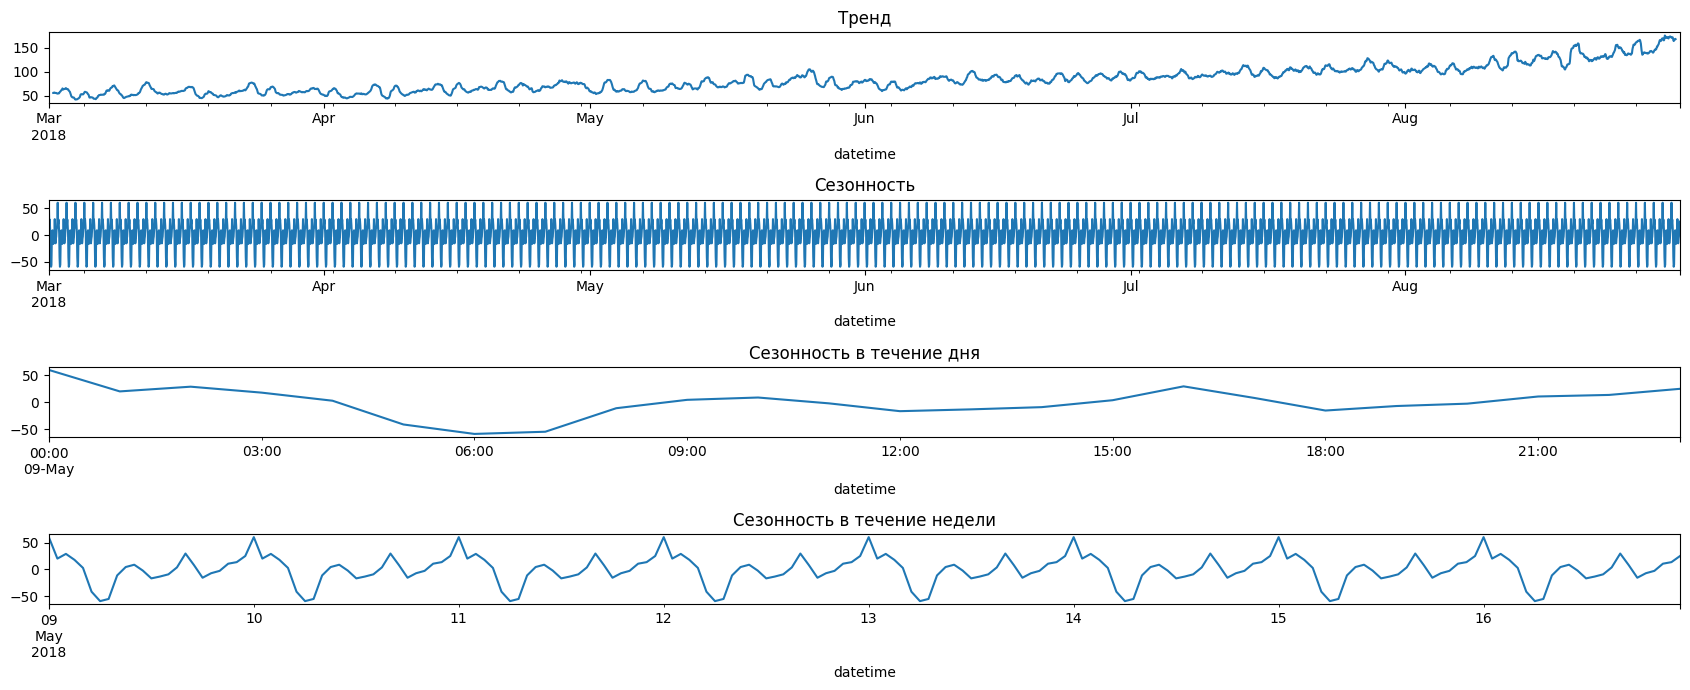

In [11]:
decompose = seasonal_decompose(data)

plt.figure(figsize=(17,7))
plt.subplot(411)
decompose.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(412)
decompose.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(413)
decompose.seasonal['2018-05-09 00:00:00':'2018-05-09 23:00:00'].plot(ax=plt.gca())
plt.title('Сезонность в течение дня')
plt.subplot(414)
decompose.seasonal['2018-05-09':'2018-05-16'].plot(ax=plt.gca())
plt.title('Сезонность в течение недели')
plt.tight_layout()

Можем заметить возрастающий тренд. Сезонность в течение дня показала пик заказов такси в 00:00, а также падение около 6 часов утра. 

## Обучение

Посмотрим на функции PACF для определения порядка модели. На приведенных ниже графиках верхняя и нижняя пунктирные линии (на втором синие закрашенные) представляют собой границы, основанные на 95% доверительном интервале.
Место, где график пересекает верхний доверительный порог - это оптимальное количество лагов, которые помогут избежать мультиколлинеарности. 

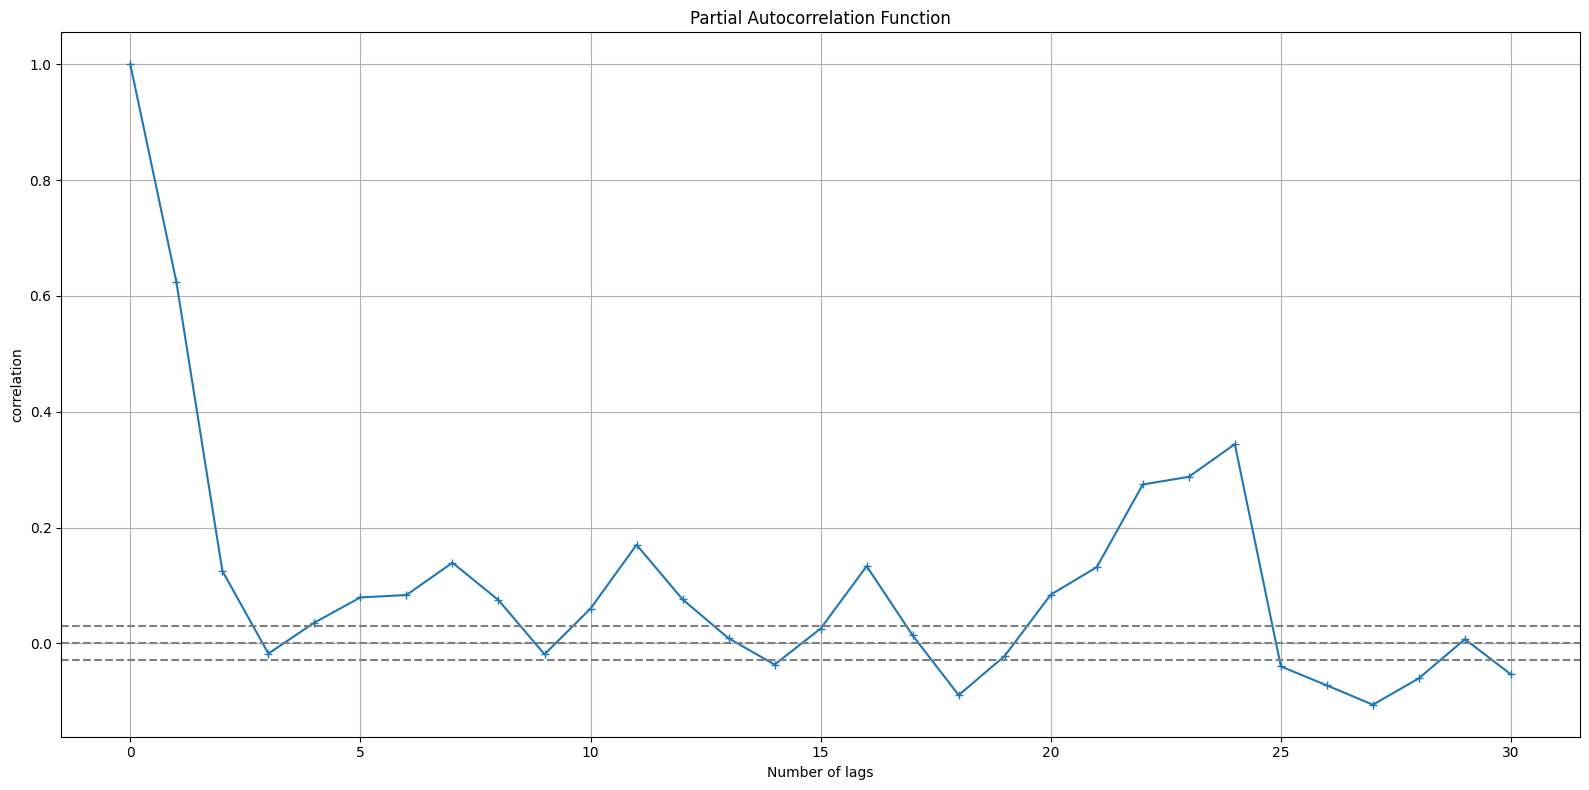

In [12]:
#PACF
lag_pacf = pacf(data['num_orders'], nlags=30, method='ols')
#Plot PACF:
plt.figure(figsize=(16, 8))
plt.plot(lag_pacf,marker='+')
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(data['num_orders'])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(data['num_orders'])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.xlabel('Number of lags')
plt.ylabel('correlation')
plt.grid()
plt.tight_layout()

Figure(640x480)


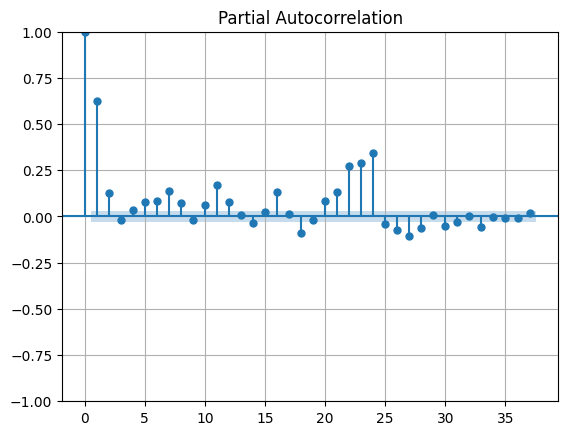

In [13]:
print(plot_pacf(data['num_orders'], method="ols"))
plt.grid()

Создадим признаки для горизонта прогнозирования в один шаг, не будем добавлять год, поскольку он везде один.

In [14]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['month'] = data.index.month
    data_new['dayofweek'] = data.index.dayofweek
    data_new['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data_new['lag_{}'.format(lag)] = data_new['num_orders'].shift(lag)

    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new

Возьмем max_lag = 24.

In [15]:
df = make_features(data,24,10)
df.dropna(inplace = True)

Посмотрим на карту корреляций. Как видим, у целевого признака хорошая корреляция с `month`, а также с `lag_1`,`lag_2`, `lag_24`, `rolling_mean`.

<AxesSubplot:>

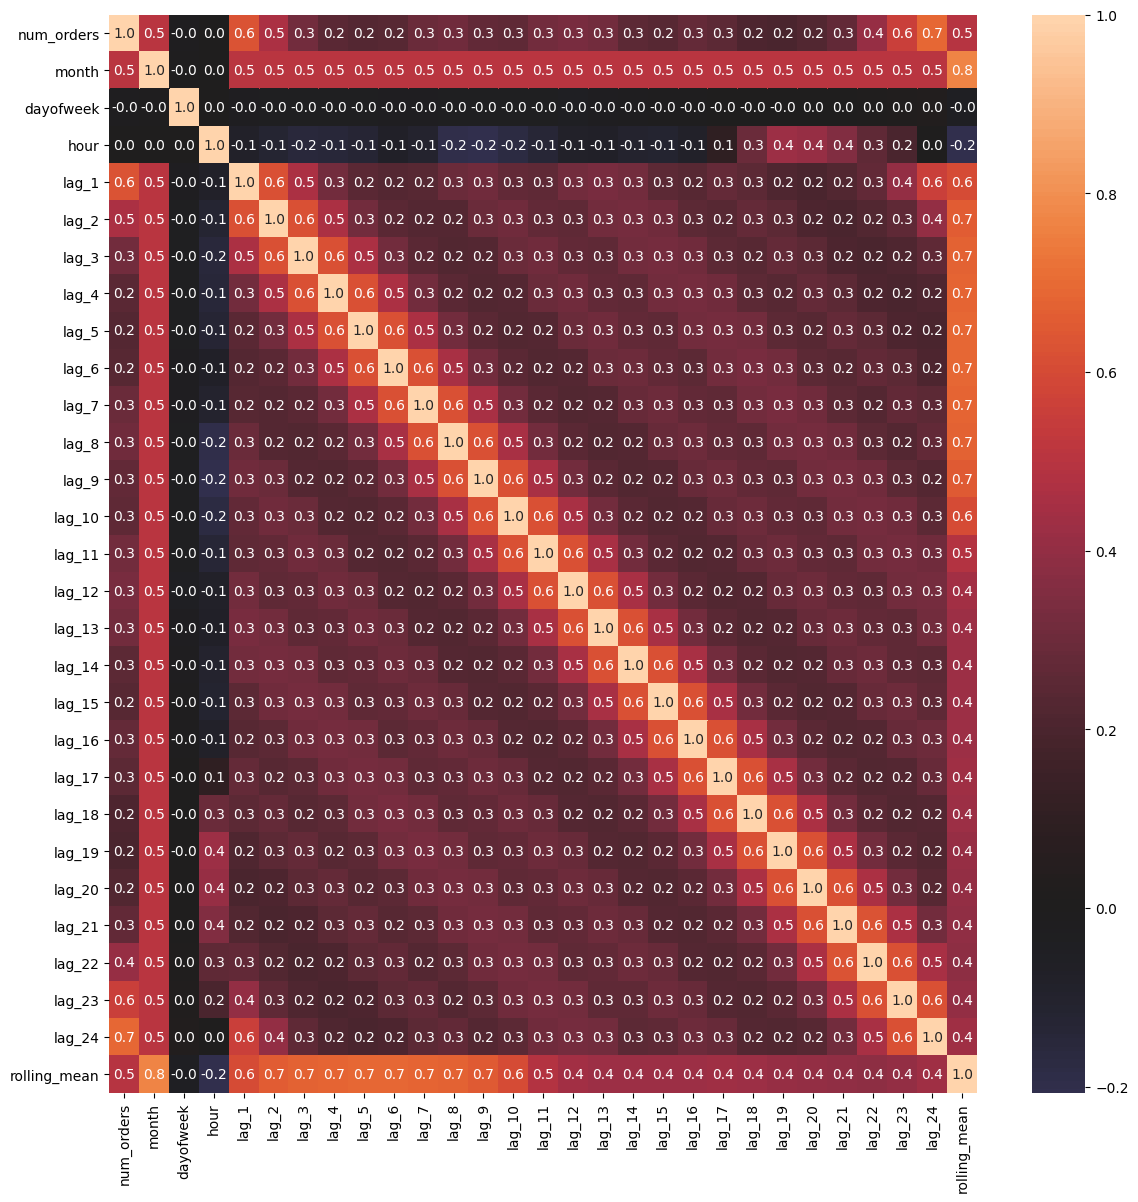

In [16]:
fig, ax = plt.subplots(figsize=(14,14)) 
sns.heatmap(df.corr(), xticklabels=df.corr().columns, 
            yticklabels=df.corr().columns, center=0, annot=True,fmt=".1f",ax=ax)

Для проверки стационарности проведем обобщенный тест Дикки-Фуллера на наличие единичных корней.

p-value меньше, чем 0.05, отвергнуть гипотезу о стационарности ряда не можем.

In [17]:
test = sm.tsa.adfuller(df['num_orders'])
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('Есть единичные корни, ряд не стационарен')
else:
    print ('Единичных корней нет, ряд стационарен')

adf:  -3.0257058283700378
p-value:  0.032562540406576565
Critical values:  {'1%': -3.431850379108881, '5%': -2.86220298394487, '10%': -2.5671229108274067}
Единичных корней нет, ряд стационарен


Разделим данные на обучающую и тестовую выборки без перемешивания.

In [18]:
features_train, features_test, target_train, target_test = train_test_split(
    df.drop('num_orders', axis = 1), df['num_orders'], shuffle = False, test_size=0.1, random_state=RANDOM_STATE)

In [19]:
print('Размер обучающей выборки: {} объектов, {} признаков'.format(features_train.shape[0], target_train.shape[0]))
print('Размер тестовой выборки: {} объектов, {} признаков'.format(features_test.shape[0], target_test.shape[0]))

Размер обучающей выборки: 3952 объектов, 3952 признаков
Размер тестовой выборки: 440 объектов, 440 признаков


### LinearRegression

In [20]:
rmse_val = cross_val_score(LinearRegression(), features_train, target_train,
                           cv=TimeSeriesSplit(n_splits=5), scoring = 'neg_root_mean_squared_error', n_jobs=-1)
print('RMSE', -rmse_val.mean())

RMSE 26.99108438695069


### CatBoost

In [21]:
%%time
param_cat = {'iterations': [100,200,300],
        'max_depth': [3,6,9],
        'learning_rate': [0.05, 0.07]
              }
cat = CatBoostRegressor(verbose = 200)
model_cat = GridSearchCV(estimator = cat, param_grid = param_cat, cv = TimeSeriesSplit(n_splits=5), n_jobs=-1, 
                         scoring='neg_root_mean_squared_error')

model_cat.fit(features_train, target_train)
print('RMSE',-model_cat.best_score_,'с параметрами',model_cat.best_params_)

0:	learn: 37.7630669	total: 176ms	remaining: 52.7s
200:	learn: 19.6298564	total: 5.91s	remaining: 2.91s
299:	learn: 17.8256802	total: 8.55s	remaining: 0us
RMSE 24.345609122372643 с параметрами {'iterations': 300, 'learning_rate': 0.05, 'max_depth': 6}
CPU times: total: 9.91 s
Wall time: 14min 15s


### LightGBM

In [22]:
model_lgbm = LGBMRegressor()
lgbm_params = {'n_estimators': [50,100,200,300],
               'num_leaves': [7,9,12]
              }
lgbm_cv = GridSearchCV(model_lgbm,
                             lgbm_params,
                             cv=TimeSeriesSplit(n_splits=5),
                             scoring = 'neg_root_mean_squared_error',
                             n_jobs=-1)

lgbm_cv.fit(features_train, target_train)
print('RMSE',-lgbm_cv.best_score_,'с параметрами',lgbm_cv.best_params_)

RMSE 24.545557604744992 с параметрами {'n_estimators': 100, 'num_leaves': 12}


**Вывод**: как и предполагалось, линейная регрессия показала худший результат.

Что касается CatBoost, LightGBM, то здесь результаты примерно одинаковые. CatBoost чуть-чуть выигрывает, возьмем её для дальнейшей прогонки на тестовой выборке.

## Тестирование

In [23]:
catboost = CatBoostRegressor(**model_cat.best_params_, random_state=RANDOM_STATE,verbose = 200)
catboost.fit(features_train,target_train)

predictions = catboost.predict(features_test)
print('RMSE',(mean_squared_error(predictions,target_test))**0.5)

0:	learn: 37.7944692	total: 39.5ms	remaining: 11.8s
200:	learn: 19.6937124	total: 5.55s	remaining: 2.73s
299:	learn: 17.9593099	total: 8.01s	remaining: 0us
RMSE 41.81251987375637


Теперь посмотрим на реальные значения и предсказанные.

In [24]:
contrast = pd.DataFrame(data = predictions, columns = ['predictions'], index = target_test.index.copy())
contrast['predictions']=contrast['predictions'].astype('int64')
contrast['true'] = target_test

<AxesSubplot:xlabel='datetime'>

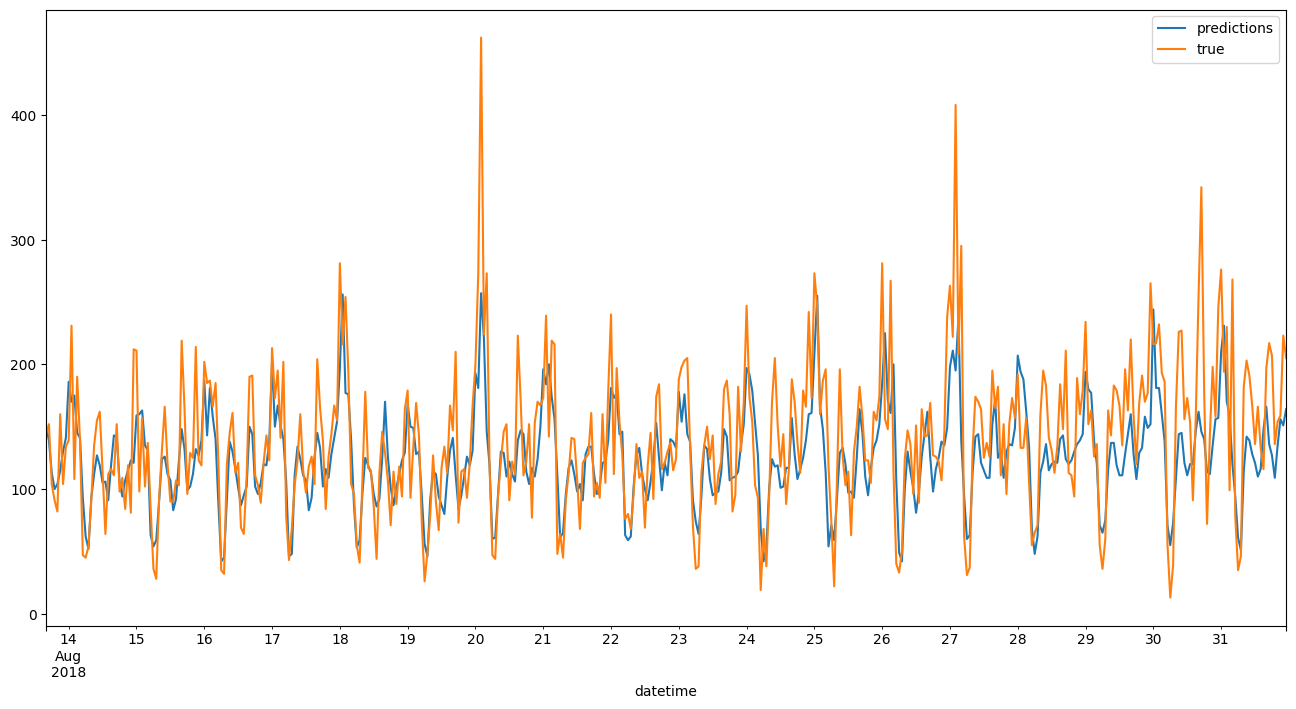

In [25]:
contrast.plot(figsize = (16,8))

А также на важность признаков. Оказалось, что час явно влияет на количество заказов.

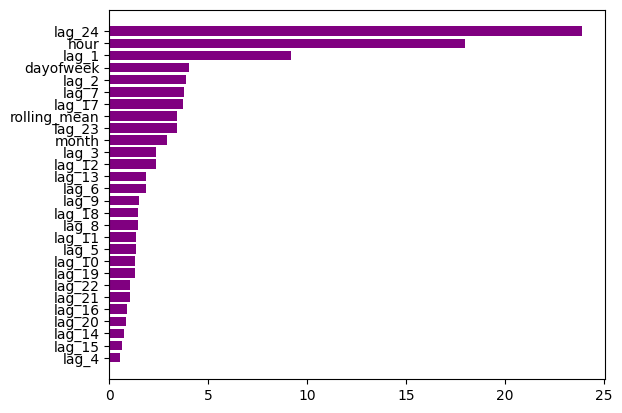

In [26]:
importances = catboost.feature_importances_
indices = np.argsort(importances)
fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices],color = 'purple')
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(features_train.columns)[indices])

## Вывод

Итак, была построена модель, предсказывающая количество заказов такси на следующий час. 

Наилучшей моделью оказалась Catboost, на тестовой выборке она показала *RMSE* = 41.8, что удовлетворяет постановке задачи.